In [12]:
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import multiclass
from scipy import sparse
from pandas.plotting import scatter_matrix
from scipy import stats,special
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import ensemble
from sklearn.utils import class_weight
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
import tensorflow as tf
from joblib import dump, load
import pickle
import keras
from IPython.display import FileLink
import seaborn as sns
import pandas as pd
import numpy as np


Let's import the dataset.

In [13]:
data = pd.read_csv('ExtraFeatures.csv')

We randomize the data first

In [14]:
data = data.sample(frac=1,random_state=5)

Remove any duplicate songs in different genres

In [15]:
data =  data.drop_duplicates(subset=data.drop(columns=['genre']).columns)

In [16]:
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,is_explicit,release_year,release_month,release_day
count,191056.000000,191056.000000,191056.000000,1.910560e+05,191056.000000,191056.000000,191056.00000,191056.000000,191056.000000,191056.000000,191056.000000,191056.000000,191051.000000,174225.000000,173899.000000
mean,37.593517,0.390859,0.541802,2.359893e+05,0.564349,0.165507,0.22197,-9.944462,0.123924,117.426531,0.452894,0.140885,2008.507823,5.915644,13.353188
std,17.600902,0.364142,0.188193,1.271222e+05,0.273886,0.317504,0.20747,6.296627,0.198276,31.234839,0.265445,0.347904,12.484087,3.662718,9.563821
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.00967,-52.457000,0.022200,30.379000,0.000000,0.000000,1899.000000,1.000000,1.000000
25%,26.000000,0.039400,0.418000,1.799070e+05,0.359000,0.000000,0.09740,-12.519000,0.036700,92.176250,0.227000,0.000000,2005.000000,2.000000,4.000000
50%,39.000000,0.264000,0.558000,2.199105e+05,0.601000,0.000068,0.13000,-8.023000,0.049300,115.107500,0.442000,0.000000,2013.000000,6.000000,13.000000
75%,50.000000,0.772000,0.681000,2.678600e+05,0.794000,0.071700,0.27400,-5.550000,0.099800,139.006250,0.665000,0.000000,2017.000000,9.000000,22.000000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.00000,3.744000,0.967000,242.903000,1.000000,1.000000,2020.000000,12.000000,31.000000


In [17]:
data.shape

(191056, 23)

In [18]:
data['genre'].value_counts()

Comedy              9679
Soundtrack          9198
Alternative         9072
Anime               8926
Electronic          8911
Blues               8902
Classical           8824
Reggaeton           8709
World               8593
Jazz                8463
Ska                 8424
Reggae              8247
Opera               8179
Country             7854
Movie               7640
Soul                6706
Folk                6686
Children’s Music    6321
Dance               6148
Rock                5476
Children's Music    5403
R&B                 5392
Indie               5134
Hip-Hop             4953
Pop                 4685
Rap                 4412
A Capella            119
Name: genre, dtype: int64

Having done the correlation matrixes for this prior we know there's very little correlation with the release_month day and weekday and the genre let's remove those aspects for now.

In [19]:
data.drop(columns=['release_month', 'release_day','release_weekday'],inplace=True)

Let's check on how many songs are explicit to see if it's a useful feature.

In [20]:
data['is_explicit'].value_counts() / (data.shape[0])

0    0.859115
1    0.140885
Name: is_explicit, dtype: float64

Let's check for null values.

In [21]:
data.isna().any()

genre               False
artist_name         False
track_name          False
track_id            False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
is_explicit         False
release_year         True
dtype: bool

There are some na values regarding the release_year, having made this dataset we know that's because of spotify's release-date precision. Let's see how many there are.

In [22]:
(data.isna().sum())/(data.shape[0])

genre               0.000000
artist_name         0.000000
track_name          0.000000
track_id            0.000000
popularity          0.000000
acousticness        0.000000
danceability        0.000000
duration_ms         0.000000
energy              0.000000
instrumentalness    0.000000
key                 0.000000
liveness            0.000000
loudness            0.000000
mode                0.000000
speechiness         0.000000
tempo               0.000000
time_signature      0.000000
valence             0.000000
is_explicit         0.000000
release_year        0.000026
dtype: float64

There's a very little amount of songs that we don't know the release_year for so we can just remove it.

In [23]:
data = data.dropna(subset=['release_year'])

So, we're noticing that A-capella has significantly less songs in that genre, we can either try merging it with another genre, getting more songs of that genre, or simply dropping it. For rn, let's simply drop it. The children's music also is split between Children's Music and Children’s Music let's combine those.

In [24]:
data =data.drop(data[data['genre'] == 'A Capella'].index)
data['genre'].value_counts()

Comedy              9679
Soundtrack          9198
Alternative         9072
Anime               8926
Electronic          8911
Blues               8902
Classical           8824
Reggaeton           8709
World               8593
Jazz                8462
Ska                 8424
Reggae              8247
Opera               8179
Country             7854
Movie               7636
Soul                6706
Folk                6686
Children’s Music    6321
Dance               6148
Rock                5476
Children's Music    5403
R&B                 5392
Indie               5134
Hip-Hop             4953
Pop                 4685
Rap                 4412
Name: genre, dtype: int64

In [25]:
replace_Children = {'genre':     {"Children's Music": 'Children’s Music'}}
data = data.replace(replace_Children)
data['genre'].value_counts()

Children’s Music    11724
Comedy               9679
Soundtrack           9198
Alternative          9072
Anime                8926
Electronic           8911
Blues                8902
Classical            8824
Reggaeton            8709
World                8593
Jazz                 8462
Ska                  8424
Reggae               8247
Opera                8179
Country              7854
Movie                7636
Soul                 6706
Folk                 6686
Dance                6148
Rock                 5476
R&B                  5392
Indie                5134
Hip-Hop              4953
Pop                  4685
Rap                  4412
Name: genre, dtype: int64

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'is_explicit'}>],
       [<AxesSubplot:title={'center':'release_year'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

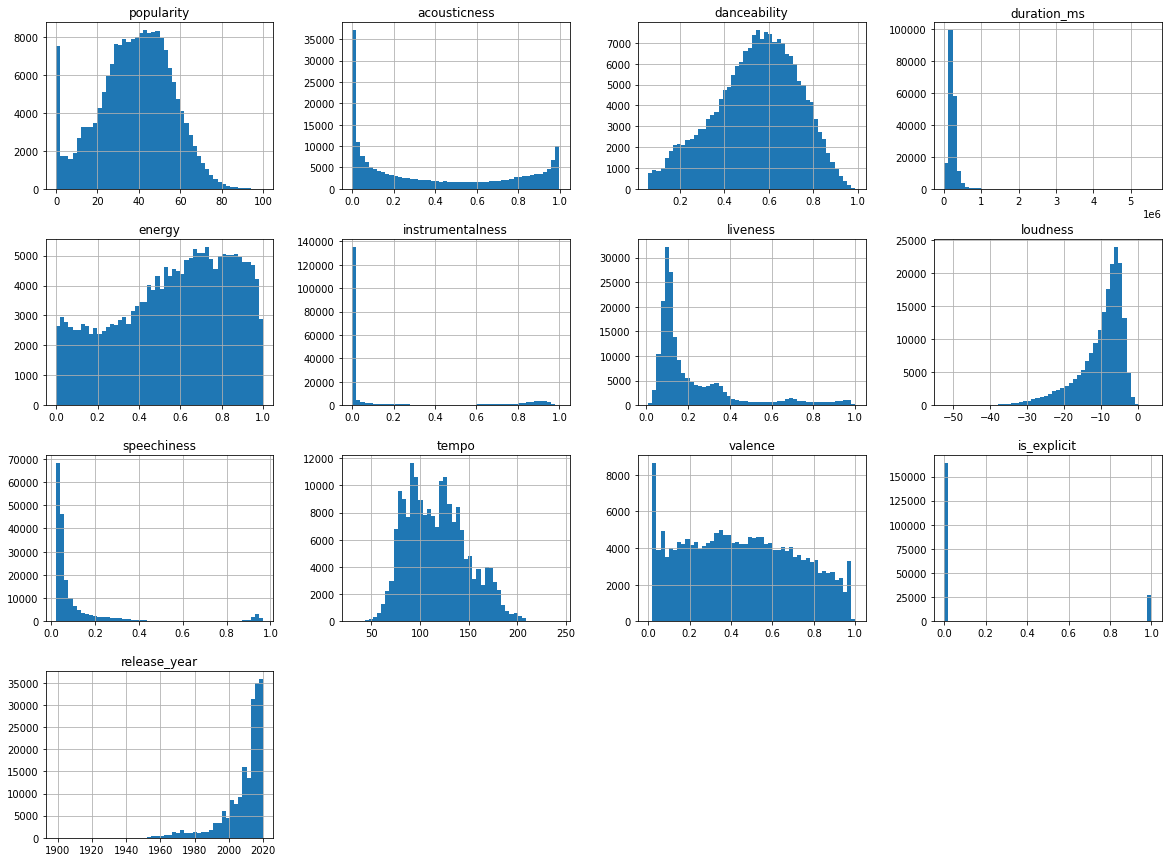

In [26]:
data.hist(bins=50,figsize=(20,15))

So we're noticing that speechiness, loudness,duration,liveness, and instrumentalness are a bit skewed let's check this to be sure.

In [27]:
data.skew(axis = 0, skipna = True)

popularity         -0.199399
acousticness        0.425671
danceability       -0.332488
duration_ms         9.565688
energy             -0.360408
instrumentalness    1.640744
liveness            1.987275
loudness           -1.527653
speechiness         3.199910
tempo               0.404343
valence             0.145487
is_explicit         2.063381
release_year       -2.058307
dtype: float64

This confirms our suspicions so far, there's definitedly some skewedness going on in those columns lets apply some log transforms to see if this works 

In [28]:
data['duration_ms'] =  np.log(data['duration_ms'])
data['duration_ms'].skew()

-0.4601599438865493

That fixed duration_ms let's try speechiness, log didn't work on this so we'll use boxcox

In [29]:
data['speechiness'] = stats.boxcox(data['speechiness'])[0]
data['speechiness'].skew()

0.3124487357598169

Instrumentalness has 0 values so in order to log it we need to add a constant.

In [30]:
data['instrumentalness'] =  np.log(data['instrumentalness']+0.00000001)
data['instrumentalness'].skew()

0.00726681950194612

Loudness can vary postively and negatively at values up to 60 so lets add a constant

In [31]:
data['loudness'] =  stats.boxcox((data['loudness']+100))[0]
data['loudness'].skew()

-0.2373418278371661

Let's use the boxcox method this as it's left skewed.

In [32]:
data['liveness'] =  stats.boxcox(data['liveness']+0.0000001)[0]
data['liveness'].skew()

0.034248433637180754

Release year is slighly more complicated to remove skew from because of the scale of the numbers let's take the log of the number first and then boxcox it.

In [33]:
log_release_year = np.log(data['release_year'])/np.log(2000)

In [34]:
data['release_year'] = stats.boxcox(log_release_year)[0]
data['release_year'].skew()

-0.4464928127304887

Let's put this in the dataset and check the full dataset again.

In [35]:
data.skew()

popularity         -0.199399
acousticness        0.425671
danceability       -0.332488
duration_ms        -0.460160
energy             -0.360408
instrumentalness    0.007267
liveness            0.034248
loudness           -0.237342
speechiness         0.312449
tempo               0.404343
valence             0.145487
is_explicit         2.063381
release_year       -0.446493
dtype: float64

Let's remove all of the columns we don't need,NOTE: We currently do not store popularity of tracks but it would not be diffucult to store it. Let's keep it for now, and if does have a signficant effect on the metrics going forward we'll use it.

In [36]:
if 'artist_name' in data.columns or 'track_id' in data.columns or 'track_name' in data.columns:
    data.drop(['artist_name', 'track_name','track_id'], axis=1,inplace=True)

We need to to do some encoding for the categorical features , so let's start with the key. Let's get all of the values.

In [37]:
data['key'].unique()

array(['D', 'E', 'A', 'C#', 'F', 'A#', 'B', 'G#', 'C', 'F#', 'G', 'D#'],
      dtype=object)

In [38]:
data['mode'].unique()

array(['Major', 'Minor'], dtype=object)

In [39]:
data['time_signature'].unique()

array(['3/4', '4/4', '1/4', '5/4', '0/4'], dtype=object)

Spotify uses pitch encoding to encode keys so we'll use the find and replace from pandas.

In [40]:
encode = {'mode':     {'Major': 1, 'Minor': 0},
                'time_signature' :{'5/4': 5, '4/4' : 4, 
                                   '3/4': 3, '2/4': 2, 
                                   '1/4' : 1, '0/4' : 0},
                'key': {'G': 7, 'E': 4, 'A': 9, 'B': 11,
                        'F': 5, 'G#': 8, 'C':0, 'C#': 1, 
                        'D':2, 'D#':3, 'F#': 6, 'A#' : 10}}
data = data.replace(encode)

Let's do a check on the encoded values.

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'time_signature'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'is_explicit'}>,
        <AxesSubplot:title={'center':'release_year'}>]], dtype=object)

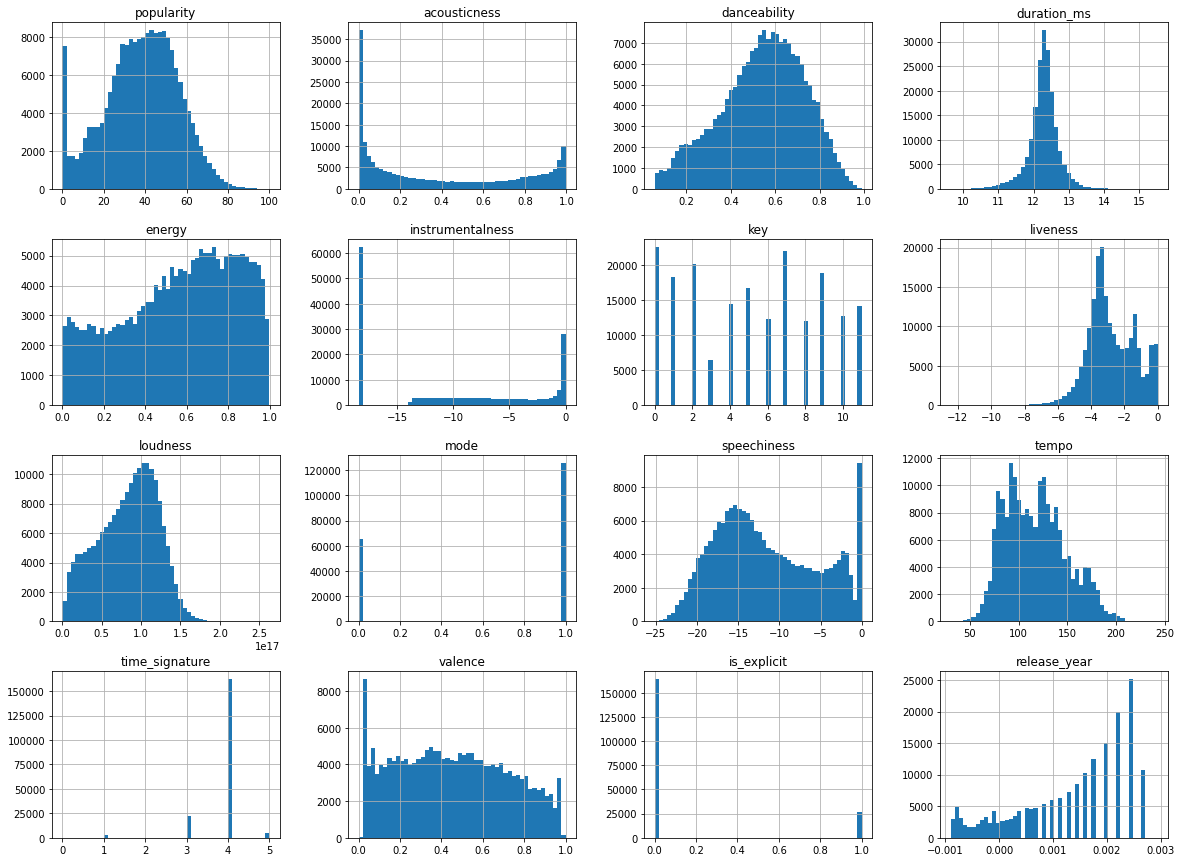

In [41]:
data.hist(bins=50,figsize=(20,15))

Time signature looks pretty skewed let's check.

In [42]:
data.skew()

popularity         -0.199399
acousticness        0.425671
danceability       -0.332488
duration_ms        -0.460160
energy             -0.360408
instrumentalness    0.007267
key                 0.015994
liveness            0.034248
loudness           -0.237342
mode               -0.667703
speechiness         0.312449
tempo               0.404343
time_signature     -2.970254
valence             0.145487
is_explicit         2.063381
release_year       -0.446493
dtype: float64

Yep, let's add a constant and try the boxcox

In [43]:
data['time_signature'] = stats.boxcox(data['time_signature'] + 0.1)[0]
data['time_signature'].skew()

0.47350732743198565

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'time_signature'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'is_explicit'}>,
        <AxesSubplot:title={'center':'release_year'}>]], dtype=object)

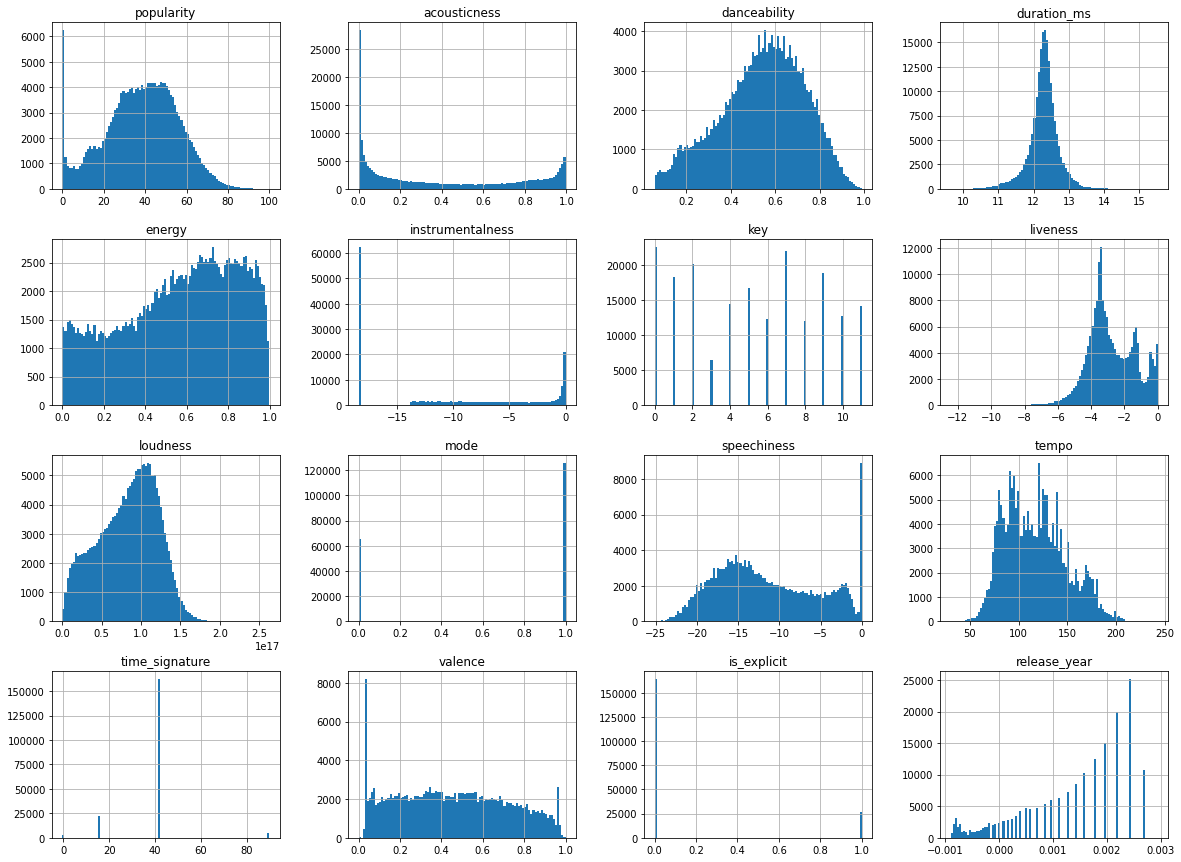

In [44]:
data.hist(bins=100,figsize=(20,15),grid=True)


Let's check for collinearity in case any of the features are too correlated.

In [45]:
vif_data = pd.DataFrame()
vif_data["feature"] = data.drop(columns=['genre']).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.drop(columns=['genre']).values, i)
                          for i in range(len(data.drop(columns=['genre']).columns))]
vif_data

,feature,VIF
0,popularity,0.836937
1,acousticness,0.595874
2,danceability,0.643655
3,duration_ms,0.007352
4,energy,3.513376
5,instrumentalness,1.122940
6,key,0.751499
7,liveness,0.567596
8,loudness,28.835979
9,mode,0.737267


Loudness seems to be linearly correlated lets drop it.

In [46]:
data = data.drop(columns=['loudness'])

While we're doing some data analysis, let's use a one hot encoder to make stuff easier to see

In [49]:
encoder = ce.one_hot.OneHotEncoder(cols=['genre'],return_df=True, use_cat_names=True)
one_hot = encoder.fit_transform(data['genre'])
one_hot_df = pd.DataFrame(one_hot)
test_data  = pd.concat([data.drop(columns=['genre']), one_hot_df], 
          axis=1)

/home/kongtj/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,...,genre_Indie,genre_Anime,genre_Pop,genre_Reggaeton,genre_Reggae,genre_Movie,genre_Jazz,genre_Folk,genre_Opera,genre_Ska
104951,49,0.987000,0.107,12.695266,0.0968,-0.789658,2,-4.419324,1,-14.589560,...,0,0,0,0,0,0,0,0,0,0
170246,25,0.930000,0.590,11.504772,0.8180,-18.420681,2,-0.330837,1,-0.064555,...,0,0,0,0,0,0,0,0,0,0
53976,66,0.730000,0.425,12.567088,0.4060,-12.534577,4,-3.488490,0,-3.774196,...,0,0,0,0,0,0,0,0,0,0
50948,26,0.289000,0.446,12.683672,0.6210,-18.420681,2,-0.016178,1,-3.178951,...,0,0,0,0,0,0,0,0,0,0
99192,55,0.069100,0.752,12.175170,0.4370,-6.151629,9,-2.900116,1,-13.323577,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33800,16,0.000109,0.516,11.339203,0.8600,-0.329894,1,-1.280634,1,-9.268096,...,0,1,0,0,0,0,0,0,0,0
59465,20,0.958000,0.278,12.605520,0.2630,-8.517143,9,-1.589468,1,-11.418581,...,0,0,0,0,0,0,0,0,1,0
232422,47,0.981000,0.514,12.202265,0.2620,-7.809133,7,-2.744915,0,-9.160956,...,0,0,0,0,0,0,0,0,0,0
124605,35,0.984000,0.114,12.914108,0.0570,-0.752897,9,-3.158462,1,-12.222279,...,0,0,0,0,0,0,0,0,0,0


In [50]:
corr_matrix = test_data.corr()
for column in data.drop(columns=['genre']).columns:
    print(f"Column:{column}\n")
    print(f'{corr_matrix[column].sort_values(ascending=False)}' )

Column:popularity

popularity                1.000000
genre_Pop                 0.263281
energy                    0.251112
danceability              0.216222
genre_Rock                0.212506
genre_Rap                 0.192275
genre_Dance               0.190733
genre_Hip-Hop             0.177396
is_explicit               0.169869
genre_Alternative         0.159706
genre_Indie               0.148703
duration_ms               0.141277
genre_R&B                 0.119015
release_year              0.117651
genre_Folk                0.111020
time_signature            0.092175
genre_Country             0.088029
tempo                     0.084544
genre_Soul                0.084115
valence                   0.055261
genre_Jazz                0.030399
key                       0.015321
genre_Electronic         -0.000721
genre_Reggaeton          -0.007431
genre_Reggae             -0.029309
genre_World              -0.032043
genre_Blues              -0.038872
genre_Soundtrack         -0.048305
s

In [51]:
corr_matrix = test_data.corr()
for genre in one_hot_df.columns:
    print(f"Genre:{genre}\n")
    print(f'{corr_matrix[genre].sort_values(ascending=False)}' )

Genre:genre_Classical

genre_Classical           1.000000
acousticness              0.289300
instrumentalness          0.229210
duration_ms               0.094426
mode                      0.005621
release_year              0.004756
key                      -0.015636
genre_Rap                -0.033855
genre_Pop                -0.034912
genre_Hip-Hop            -0.035923
genre_Indie              -0.036591
genre_R&B                -0.037525
genre_Rock               -0.037825
genre_Dance              -0.040152
genre_Folk               -0.041933
genre_Soul               -0.041998
genre_Movie              -0.044929
genre_Country            -0.045593
genre_Opera              -0.046568
genre_Reggae             -0.046770
genre_Ska                -0.047292
genre_Jazz               -0.047403
genre_World              -0.047786
genre_Reggaeton          -0.048123
genre_Blues              -0.048679
genre_Electronic         -0.048705
genre_Anime              -0.048748
genre_Alternative        -0.0491

Noticing a few things, indie seems to have relatively little correlation values and looking into it more indie isn't really a genre anyway let's remove it.

In [52]:
data = data[data['genre'] != 'Indie']

<AxesSubplot:>

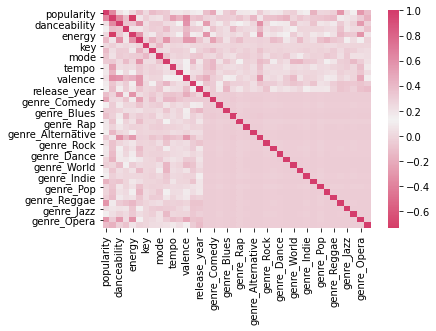

In [53]:
sns.heatmap(corr_matrix,cmap=sns.diverging_palette(-359, 359, n=300))

Lets split the data into x and y portions, 

Still haven't figured out why tbh as the genre's shouldn't have any particular order but for whatever reason label encoder is working much better than the other encoding methods. My guess is that either A there is some relationship there in the genre's order outside of the number or B it just couldnt' find a discernable order.

In [55]:
Xval = data.drop(columns=['genre'])
encoder = preprocessing.LabelEncoder()
Yval = encoder.fit_transform(data['genre'])

Genre is categorical data, so we need to encode it, and unfortunately there are ~300 genres to work with so we can't just use One hot encoding for the actual model so we'll use binary encoding instead

In [56]:
x_train, x_test, y_train, y_test = train_test_split (Xval, Yval, test_size = 0.2, random_state = 29,stratify=Yval)

In [57]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [58]:
pd.DataFrame(y_train).value_counts()

3     9379
5     7743
22    7358
0     7257
1     7141
8     7129
2     7122
4     7059
18    6967
23    6874
11    6770
20    6739
17    6598
13    6543
6     6283
12    6109
21    5365
9     5349
7     4918
19    4381
15    4314
10    3962
14    3748
16    3530
dtype: int64

In [59]:
nn_class_weights  = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
nn_class_weights = {l:c for l,c in zip(np.unique(y_train), nn_class_weights)}

In [60]:
def topkscore(preds, ground_truth, model,k):
    if not len(preds) == len(ground_truth):
        raise exception('Shape Mismatch')
    
    mdfd_pred = []
    for i in range(len(preds)):
        preds_classes = model.classes_[preds[i].argsort()[::-1][:k]]
        if ground_truth[i] in preds_classes :
            mdfd_pred.append(ground_truth[i])
        else:
            mdfd_pred.append(preds_classes[0])
    return mdfd_pred

In [61]:
def eval_model(model,x_train,x_test,y_train,y_test):
#   print("Single Value scores:")
#   scores = cross_val_score (model, x_train, y_train, cv= 5, scoring = 'f1_macro', n_jobs= -1 )
#   print ('f1 macro %s' % str (np.mean(scores)))
#   scores = cross_val_score (model, x_train, y_train, cv = 5, scoring = 'precision_macro', n_jobs = -1)
#   print ('precision macro %s' % str (np.mean(scores)))
#   scores = cross_val_score (model, x_train, y_train, cv = 5, scoring = 'recall_macro', n_jobs = -1)
#   print ('recall macro %s' % str (np.mean(scores)))
  model.fit(x_train,y_train)
  x_scaled_test = scaler.transform(x_test)
  y_pred = model.predict_proba(x_scaled_test)
  y_pred = topkscore(y_pred,y_test,model,3)
  y_pred_label = encoder.inverse_transform(y_pred)
  y_test_label = encoder.inverse_transform(y_test)
  metric= metrics.classification_report (y_pred_label,y_test_label)
  print (metric)
  print(f"Metrics: F1 Score Macro: {metrics.f1_score(y_test, y_pred, average='macro')}")
  print(f"Metrics: Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
  return model

It's time for some model evaluation, judging from the correlation coefficients a simple linear model won't cut it. 
Lets try Random Forests, SVM's, Quadratic Discriminant Analysis, KNN's and since we have a good amount of data let's see how an MLP classifier does to judge if we can try a deep nn.

In [62]:
params = {
            'reg_param': [x for x in np.linspace(start = 0, stop = 1, num = 10)]
         }

In [63]:
model = QuadraticDiscriminantAnalysis()
QuadModel = eval_model(model,x_train,x_test,y_train,y_test)

                  precision    recall  f1-score   support

     Alternative       0.48      0.62      0.54      1393
           Anime       0.79      0.67      0.73      2124
           Blues       0.70      0.68      0.69      1834
Children’s Music       0.41      0.90      0.57      1076
       Classical       0.87      0.79      0.83      1939
          Comedy       0.94      0.98      0.96      1857
         Country       0.67      0.53      0.59      2001
           Dance       0.58      0.56      0.57      1262
      Electronic       0.70      0.68      0.69      1835
            Folk       0.57      0.62      0.59      1239
         Hip-Hop       0.78      0.66      0.71      1164
            Jazz       0.53      0.72      0.61      1249
           Movie       0.84      0.79      0.81      1610
           Opera       0.97      0.82      0.89      1919
             Pop       0.71      0.77      0.73       863
             R&B       0.43      0.54      0.48       853
             

In [64]:
params = {
            'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 2000, num = 50)],
            'max_features' : list(range(1,15,1)),
            'bootstrap'     : [True,False],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'max_depth'    : [int(x) for x in np.linspace(10, 110, num = 11)],
         }
         

In [65]:
model = ensemble.RandomForestClassifier()
RFModel = eval_model(model,x_train,x_test,y_train,y_test)

                  precision    recall  f1-score   support

     Alternative       0.61      0.54      0.57      2059
           Anime       0.86      0.89      0.87      1724
           Blues       0.77      0.75      0.76      1834
Children’s Music       0.71      0.75      0.73      2231
       Classical       0.90      0.91      0.91      1749
          Comedy       0.97      0.99      0.98      1884
         Country       0.73      0.68      0.70      1690
           Dance       0.57      0.59      0.58      1189
      Electronic       0.80      0.80      0.80      1779
            Folk       0.66      0.66      0.66      1330
         Hip-Hop       0.81      0.76      0.78      1052
            Jazz       0.78      0.78      0.78      1695
           Movie       0.90      0.93      0.92      1482
           Opera       0.97      0.98      0.97      1630
             Pop       0.80      0.70      0.75      1059
             R&B       0.54      0.59      0.56       992
             

In [66]:
important_features = pd.Series(data=RFModel.feature_importances_,index=Xval.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features

popularity          0.152655
speechiness         0.096718
acousticness        0.089182
danceability        0.085731
energy              0.082927
duration_ms         0.078555
instrumentalness    0.073540
valence             0.073392
release_year        0.068778
liveness            0.064526
tempo               0.063061
key                 0.038100
is_explicit         0.013730
mode                0.011486
time_signature      0.007619
dtype: float64

In [67]:
model = neighbors.KNeighborsClassifier()
KNNModel = eval_model(model,x_train,x_test,y_train,y_test)

                  precision    recall  f1-score   support

     Alternative       0.48      0.32      0.38      2747
           Anime       0.75      0.73      0.74      1821
           Blues       0.63      0.68      0.65      1649
Children’s Music       0.62      0.72      0.66      2009
       Classical       0.79      0.82      0.80      1700
          Comedy       0.96      0.96      0.96      1936
         Country       0.58      0.55      0.56      1644
           Dance       0.30      0.45      0.36       814
      Electronic       0.60      0.69      0.64      1542
            Folk       0.34      0.47      0.39       982
         Hip-Hop       0.62      0.53      0.57      1154
            Jazz       0.61      0.47      0.53      2160
           Movie       0.69      0.88      0.77      1188
           Opera       0.92      0.85      0.89      1764
             Pop       0.46      0.62      0.53       696
             R&B       0.35      0.48      0.40       781
             

In [53]:
model = svm.SVC(probability=True)
SVMModel = eval_model(model,x_train,x_test,y_train,y_test)

Single Value scores:
f1 macro 0.4839719717069417
precision macro 0.4874920998608515
recall macro 0.4891888345721694
                  precision    recall  f1-score   support

     Alternative       0.70      0.68      0.69      1850
           Anime       0.85      0.85      0.85      1772
           Blues       0.76      0.76      0.76      1772
Children’s Music       0.74      0.86      0.80      2011
       Classical       0.89      0.88      0.89      1772
          Comedy       0.97      0.99      0.98      1904
         Country       0.73      0.65      0.69      1766
           Dance       0.59      0.64      0.61      1133
      Electronic       0.80      0.75      0.77      1916
            Folk       0.69      0.65      0.67      1401
         Hip-Hop       0.83      0.74      0.78      1113
            Jazz       0.78      0.74      0.76      1779
           Movie       0.88      0.89      0.88      1505
           Opera       0.95      0.96      0.96      1613
             

In [68]:
model = MLPClassifier(max_iter=100)
MLPModel = eval_model(model,x_train,x_test,y_train,y_test)

/home/kongtj/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                  precision    recall  f1-score   support

     Alternative       0.70      0.67      0.69      1896
           Anime       0.85      0.88      0.87      1740
           Blues       0.75      0.80      0.77      1670
Children’s Music       0.72      0.89      0.80      1902
       Classical       0.90      0.88      0.89      1803
          Comedy       0.97      0.99      0.98      1904
         Country       0.71      0.69      0.70      1606
           Dance       0.66      0.57      0.61      1431
      Electronic       0.80      0.77      0.78      1854
            Folk       0.68      0.59      0.63      1540
         Hip-Hop       0.81      0.68      0.74      1185
            Jazz       0.74      0.78      0.76      1615
           Movie       0.89      0.93      0.91      1471
           Opera       0.96      0.98      0.97      1603
             Pop       0.83      0.67      0.74      1153
             R&B       0.63      0.60      0.62      1118
             

In [58]:
input_shape = pd.DataFrame(x_train).shape

In [59]:
len(pd.Series(y_train).unique())

24

In [60]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoint_cb = keras.callbacks.ModelCheckpoint("KerasModel.h5",save_best_only=True,options=save_locally)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
class PrintValTrainRatioCallBack(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print(f"\n val/train:{logs['val_loss']/logs['loss']}")
print_cb = PrintValTrainRatioCallBack()

In [61]:
param_distribs = {
    'n_hidden' : [0,1,2,3,4],
    'n_neurons' : np.arange(1,100),
    'learning_rate': stats.reciprocal(3e-4,3e-1),
}

In [65]:
def build_model(n_hidden = 5,n_neurons=300,learning_rate=1e-3,input_shape=[input_shape[1]]):
        model = keras.models.Sequential()
        model.add(keras.layers.Flatten(input_shape=input_shape))
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(n_neurons,activation="relu"))
        model.add(keras.layers.Dense(25,activation="softmax"))
        optimizer = keras.optimizers.SGD(lr=learning_rate)
        model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3))
        return model
keras_class = build_model()

In [66]:
keras_class.fit(x_train,y_train,epochs=100,validation_split=0.2,callbacks=[print_cb,early_stopping_cb,checkpoint_cb])

Epoch 1/100
3716/3716 [==============================] - 13s 4ms/step - loss: 3.1698 - sparse_top_k_categorical_accuracy: 0.1953 - val_loss: 2.9360 - val_sparse_top_k_categorical_accuracy: 0.3178

 val/train:0.9445055257324623
Epoch 2/100
3716/3716 [==============================] - 15s 4ms/step - loss: 2.8009 - sparse_top_k_categorical_accuracy: 0.3766 - val_loss: 2.4079 - val_sparse_top_k_categorical_accuracy: 0.5104

 val/train:0.903126823399064
Epoch 3/100
3716/3716 [==============================] - 16s 4ms/step - loss: 2.2932 - sparse_top_k_categorical_accuracy: 0.5568 - val_loss: 2.0225 - val_sparse_top_k_categorical_accuracy: 0.6476

 val/train:0.9231925580156217
Epoch 4/100
3716/3716 [==============================] - 16s 4ms/step - loss: 1.9650 - sparse_top_k_categorical_accuracy: 0.6607 - val_loss: 1.8405 - val_sparse_top_k_categorical_accuracy: 0.6917

 val/train:0.962746637538187
Epoch 5/100
3716/3716 [==============================] - 16s 4ms/step - loss: 1.8053 - sparse_

3716/3716 [==============================] - 15s 4ms/step - loss: 1.4808 - sparse_top_k_categorical_accuracy: 0.7829 - val_loss: 1.5055 - val_sparse_top_k_categorical_accuracy: 0.7762

 val/train:1.017540898266029
Epoch 38/100
3716/3716 [==============================] - 15s 4ms/step - loss: 1.4754 - sparse_top_k_categorical_accuracy: 0.7836 - val_loss: 1.5013 - val_sparse_top_k_categorical_accuracy: 0.7780

 val/train:1.0165618120517654
Epoch 39/100
3716/3716 [==============================] - 15s 4ms/step - loss: 1.4659 - sparse_top_k_categorical_accuracy: 0.7856 - val_loss: 1.5029 - val_sparse_top_k_categorical_accuracy: 0.7766

 val/train:1.0195783795114932
Epoch 40/100
3716/3716 [==============================] - 16s 4ms/step - loss: 1.4769 - sparse_top_k_categorical_accuracy: 0.7838 - val_loss: 1.4997 - val_sparse_top_k_categorical_accuracy: 0.7771

 val/train:1.0192379733602261
Epoch 41/100
3716/3716 [==============================] - 19s 5ms/step - loss: 1.4683 - sparse_top_k_c

3716/3716 [==============================] - 91s 25ms/step - loss: 1.4013 - sparse_top_k_categorical_accuracy: 0.7997 - val_loss: 1.4528 - val_sparse_top_k_categorical_accuracy: 0.7861

 val/train:1.0344200332198477
Epoch 74/100
3716/3716 [==============================] - 11s 3ms/step - loss: 1.4055 - sparse_top_k_categorical_accuracy: 0.7989 - val_loss: 1.4501 - val_sparse_top_k_categorical_accuracy: 0.7875

 val/train:1.033777576985845
Epoch 75/100
3716/3716 [==============================] - 17s 5ms/step - loss: 1.3924 - sparse_top_k_categorical_accuracy: 0.8033 - val_loss: 1.4511 - val_sparse_top_k_categorical_accuracy: 0.7874

 val/train:1.035872193344367
Epoch 76/100
3716/3716 [==============================] - 17s 5ms/step - loss: 1.4003 - sparse_top_k_categorical_accuracy: 0.7992 - val_loss: 1.4525 - val_sparse_top_k_categorical_accuracy: 0.7876

 val/train:1.037768842538221
Epoch 77/100
3716/3716 [==============================] - 19s 5ms/step - loss: 1.3950 - sparse_top_k_ca

In [53]:
x_scaled_test = scaler.fit_transform(x_test)
y_pred = keras_class.predict_classes(x_scaled_test)
# y_pred = topkscore(y_pred,y_test,keras_class,3)
y_pred_label = encoder.inverse_transform(y_pred)
y_test_label = encoder.inverse_transform(y_test)
metric= metrics.classification_report (y_pred_label,y_test_label)
print (metric)
print(f"Metrics: F1 Score Macro: {metrics.f1_score(y_test, y_pred, average='macro')}")
print(f"Metrics: Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

/home/kongtj/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

     Alternative       0.03      0.04      0.04      1549
           Anime       0.05      0.05      0.05      1814
           Blues       0.09      0.05      0.06      3396
Children’s Music       0.04      0.06      0.05      1691
       Classical       0.01      0.01      0.01      1013
          Comedy       0.00      0.01      0.01      1199
         Country       0.00      0.02      0.01       309
           Dance       0.04      0.06      0.04       762
      Electronic       0.07      0.06      0.07      2077
            Folk       0.04      0.03      0.04      1652
         Hip-Hop       0.00      0.00      0.00       627
            Jazz       0.03      0.02      0.02      2182
           Movie       0.05      0.03      0.04      2125
           Opera       0.00      0.00      0.00       659
             Pop       0.03      0.02      0.02      1829
             R&B       0.02      0.02      0.02       993
             

In [61]:
votingCLF= ensemble.VotingClassifier(estimators=[('SVM',svm.SVC(probability=True)),('RF',ensemble.RandomForestClassifier(n_estimators=100)),('MLP',MLPClassifier(max_iter=400))],voting='soft',n_jobs=1)

In [62]:
votingCLF = eval_model(votingCLF,x_train,x_test,y_train,y_test)
dump(votingCLF,'Voting.joblib')

Single Value scores:
f1 macro 0.4951894108365032
precision macro 0.4955416433260756
recall macro 0.4997332383335717
                  precision    recall  f1-score   support

     Alternative       0.65      0.63      0.64      1875
           Anime       0.87      0.89      0.88      1736
           Blues       0.75      0.78      0.76      1708
Children’s Music       0.74      0.81      0.77      2115
       Classical       0.92      0.90      0.91      1798
          Comedy       0.97      0.99      0.98      1896
         Country       0.76      0.69      0.72      1732
           Dance       0.58      0.62      0.60      1148
      Electronic       0.81      0.79      0.80      1831
            Folk       0.67      0.65      0.66      1387
         Hip-Hop       0.83      0.73      0.77      1147
            Jazz       0.79      0.75      0.77      1780
           Movie       0.90      0.92      0.91      1486
           Opera       0.96      0.98      0.97      1609
             

['Voting.joblib']